voxels.shape: (8, 8, 8)
voxels[1, 1, 1]: False
voxels[4, 4, 4]: True
colors.shape: (8, 8, 8)
colors[1, 1, 1]: None
colors[4, 4, 4]: blue


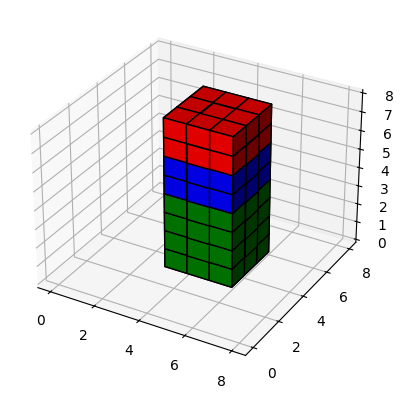

In [1]:
# * from 3d artefacts code: https://github.com/real-itu/3d-artefacts-nca/blob/master/notebooks/CustomVoxel.ipynb

import matplotlib.pyplot as plt
import numpy as np

# prepare some coordinates
x, y, z = np.indices((8, 8, 8))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z < 4)
cube2 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 4) & (z < 6)
cube3 = (x <= 5) & (x >= 3) & (y <= 5) & (y >= 3) & (z >= 6) & (z < 8) 

# link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | cube3
print ('voxels.shape:',voxels.shape)
print ('voxels[1, 1, 1]:',voxels[1, 1, 1])
print ('voxels[4, 4, 4]:',voxels[4, 4, 4])

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[cube3] = 'red'
colors[cube1] = 'green'
colors[cube2] = 'blue'

# and plot everything
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

print ('colors.shape:',colors.shape)
print ('colors[1, 1, 1]:',colors[1, 1, 1])
print ('colors[4, 4, 4]:',colors[4, 4, 4])
ax.voxels(colors, facecolors=colors, edgecolor='k')

plt.show()

In [2]:
# * from example code: https://matplotlib.org/stable/gallery/mplot3d/voxels_rgb.html

def midpoints(x):
    sl = ()
    for _ in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# prepare some coordinates, and attach rgb values to each
r, g, b = np.indices((17, 17, 17)) / 16.0
rc = midpoints(r)
gc = midpoints(g)
bc = midpoints(b)

print ('rc.shape:',rc.shape)

# define a sphere about [0.5, 0.5, 0.5]
sphere = (rc - 0.5)**2 + (gc - 0.5)**2 + (bc - 0.5)**2 < 0.5**2
print ('sphere.shape:',sphere.shape)

# combine the color components
colors = np.zeros(sphere.shape + (3,))
colors[..., 0] = rc
colors[..., 1] = gc
colors[..., 2] = bc
print ('colors.shape:',colors.shape)

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(r, g, b, sphere,
          facecolors=colors,
          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          linewidth=1)
ax.set(xlabel='r', ylabel='g', zlabel='b')
ax.set_aspect('equal')

plt.show()

rc.shape: (16, 16, 16)
sphere.shape: (16, 16, 16)
colors.shape: (16, 16, 16, 3)


In [ ]:
from Vox import Vox
from VoxelNCA import create_seed
from VoxelPerception import VoxelPerception as vp
from VoxelPerception import X_SOBEL_KERN, Y_SOBEL_KERN, Z_SOBEL_KERN, LAP_KERN

_3x3x3 = Vox().load_from_file('_vox_files/3x3x3.vox')
knight = Vox().load_from_file('_vox_files/knight.vox')
burger = Vox().load_from_file('_vox_files/burger.vox')
trex = Vox().load_from_file('_vox_files/t_rex.vox')

# * make sure Vox.tensor() works as expeccted
burger.render()
burger_ten = burger.tensor()
burger_ten_vox = Vox().load_from_tensor(burger_ten)
burger_ten_vox.render()

seed = create_seed(_dist=3, _points=4)
seed_vox = Vox().load_from_tensor(seed)
seed_vox.render()
# seed_vox.orbit('_videos/seed.mp4', _delta=5, _show_grid=True)

t = trex.tensor()
p = vp('cpu')
sx = vp.per_channel_conv3d(p, t, X_SOBEL_KERN[None, :])
sy = vp.per_channel_conv3d(p, t, Y_SOBEL_KERN[None, :])
sz = vp.per_channel_conv3d(p, t, Z_SOBEL_KERN[None, :])
lap = vp.per_channel_conv3d(p, t, LAP_KERN[None, :])

# _sx = Vox().load_from_tensor(sx)
# _sx.orbit('_videos/trex_sx.mp4', _delta=5, _show_grid=True)

# _sy = Vox().load_from_tensor(sy)
# _sy.orbit('_videos/trex_sy.mp4', _delta=5, _show_grid=True)

# _sz = Vox().load_from_tensor(sz)
# _sz.orbit('_videos/trex_sz.mp4', _delta=5, _show_grid=True)

# _lap = Vox().load_from_tensor(lap)
# _lap.orbit('_videos/trex_lap.mp4', _delta=5, _show_grid=True)

In [ ]:
import torch
import json
import pathlib
import matplotlib.pylab as pl
import torch.nn.functional as func
from VoxelNCA import VoxelNCA, create_seed, voxel_wise_loss_function, show_batch
from tqdm import tqdm
from IPython.display import clear_output

_EPOCHS_ = 0
_NAME_ = 'burger_v1'
_POOL_SIZE_ = 32
_BATCH_SIZE_ = 4
_PAD_ = 4
_LOWER_LR_ = 1e-5
_UPPER_LR_ = 1e-3

_INFO_RATE_ = 100
_SAVE_RATE_ = 1000
_VIDEO_RATE_ = 1000

# * find GPU available
clear_output()
!nvidia-smi -L

# * sets the device
# *     defaults to 'cuda'
_DEVICE_ = 'cuda' if torch.cuda.is_available() else 'cpu'
print ('cuda available? ', torch.cuda.is_available())
print ('device: ', _DEVICE_)

torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# * model
model = VoxelNCA(_device=_DEVICE_)
model_type = model.model_type
opt = torch.optim.Adam(model.parameters(), _UPPER_LR_)
lr_sched = torch.optim.lr_scheduler.CyclicLR(opt, _LOWER_LR_, _UPPER_LR_, step_size_up=2000, mode='triangular2', cycle_momentum=False)

# * load checkpoint
load_checkpoint = True
checkpoint = '_models/burger_v1'
params = {}
if load_checkpoint:
    with open(checkpoint+'_params.json', 'r') as openfile:
        params = json.load(openfile)
        
        # * load in params
        _NAME_ = params['_NAME_']
        _POOL_SIZE_ = params['_POOL_SIZE_']
        _BATCH_SIZE_ = params['_BATCH_SIZE_']
        _PAD_ = params['_PAD_']
        _LOWER_LR_ = params['_LOWER_LR_']
        _UPPER_LR_ = params['_UPPER_LR_']
        
        # * load state dictionary
        model.load_state_dict(torch.load(checkpoint + '.pt', map_location=_DEVICE_))   
        model.train()
        print ('loaded checkpoint: '+checkpoint)

# * target
burger = Vox().load_from_file('_vox_files/burger.vox')
target_ten = burger.tensor()
target_ten = func.pad(target_ten, (_PAD_, _PAD_, _PAD_, _PAD_, _PAD_, _PAD_), 'constant')
target_ten = target_ten.clone().repeat(_BATCH_SIZE_, 1, 1, 1, 1).to(_DEVICE_)
print ('target_ten.shape:',target_ten.shape)
seed_vox = Vox().load_from_tensor(target_ten)
seed_vox.render()

# * seed
seed_ten = create_seed( _size=16+(2*_PAD_), _dist=3, _points=4).unsqueeze(0).to(_DEVICE_)
print ('seed_ten.shape:',seed_ten.shape)
seed_vox = Vox().load_from_tensor(seed_ten)
seed_vox.render()

# * pool
with torch.no_grad():
    pool = seed_ten.clone().repeat(_POOL_SIZE_, 1, 1, 1, 1)
print ('pool.shape:',pool.shape)

# * save model method
def save_model(_dir, _model, _name):
    model_path = pathlib.Path(_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    torch.save(_model.state_dict(), _dir + '/' + _name + '.pt')
    
    # * save model parameters
    dict = {
        '_EPOCHS_': _EPOCHS_,
        '_NAME_': _NAME_,
        '_DEVICE_': _DEVICE_,
        '_POOL_SIZE_': _POOL_SIZE_,
        '_BATCH_SIZE_': _BATCH_SIZE_,
        '_PAD_': _PAD_,
        '_LOWER_LR_': _LOWER_LR_,
        '_UPPER_LR_': _UPPER_LR_
    }
    json_object = json.dumps(dict, indent=4)
    with open(_dir + '/' + _name + '_params.json', 'w') as outfile:
        outfile.write(json_object)
    print ('model + params saved!')

# * train
loss_log = []
progress = 0
for _ in tqdm(range(_EPOCHS_)):
    with torch.no_grad():
        # * sample batch from pool
        i = len(loss_log)
        batch_idxs = np.random.choice(_POOL_SIZE_, _BATCH_SIZE_, replace=False)
        x = pool[batch_idxs]
        
        # * re-order batch based on loss
        loss_ranks = torch.argsort(voxel_wise_loss_function(x, target_ten, _dims=[-1, -2, -3, -4]), descending=True)
        x = x[loss_ranks]
        
        # * re-add seed into batch
        x[:1] = seed_ten
        
    # * save batch before
    if i % _INFO_RATE_ == 0:
        before = x.detach().cpu()

    # * different loss values
    overflow_loss = 0.0
    diff_loss = 0.0
    target_loss = 0.0
    
    # * forward pass
    num_steps = np.random.randint(64, 96)
    for _ in range(num_steps):
        prev_x = x
        x = model(x)
        diff_loss += (x - prev_x).abs().mean()
        if model_type == 'STEERABLE':
            overflow_loss += (x - x.clamp(-2.0, 2.0))[:, :15].square().sum()
        else:
            overflow_loss += (x - x.clamp(-2.0, 2.0))[:, :16].square().sum()
    
    # * calculate losses
    target_loss += voxel_wise_loss_function(x, target_ten)
    target_loss /= 2.0
    diff_loss *= 10.0
    loss = target_loss + overflow_loss + diff_loss
    
    # * backward pass
    with torch.no_grad():
        loss.backward()
        # * normalize gradients 
        for p in model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        opt.step()
        opt.zero_grad()
        lr_sched.step()
        # * re-add batch to pool
        pool[batch_idxs] = x
        loss_log.append(loss.item())
        
        # * print out info
        if i % _INFO_RATE_ == 0:
            # * show loss plot
            clear_output(True)
            pl.plot(loss_log, '.', alpha=0.1)
            pl.yscale('log')
            pl.ylim(np.min(loss_log), loss_log[0])
            pl.show()
            
            # * show batch
            after = x.detach().cpu()
            show_batch(_BATCH_SIZE_, before, after)
            
            # * print info
            print('\rstep:', i, '\tloss:', loss.item(), '\tmin-loss:', np.min(loss_log),  '\tlr:', lr_sched.get_last_lr()[0], end='')
                
        # * save checkpoint
        if i % _SAVE_RATE_ == 0 and i != 0:
            save_model('_checkpoints', model, _NAME_+'_cp'+str(i))
            
        # * create video
        if i % _VIDEO_RATE_ == 0:
            model.generate_video(f'_videos/{_NAME_}_cp{i}.mp4', seed_ten, _steps=128, _delta=2)

# * save final model
save_model('_models', model, _NAME_)
with torch.no_grad():
    model.generate_video(f'_videos/{_NAME_}_final.mp4', seed_ten, _steps=256, _delta=2)